In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler
import math

2022-12-15 21:21:39.892058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 21:21:40.974196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benk/root/root-6.26.10-install/lib
2022-12-15 21:21:40.974229: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 21:21:44.158283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cann

In [2]:
#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, list_IDs, labelsFunc, useWeightObj = False, weightObj = 0, batch_size=32, dim=(14), n_channels=1, n_classes=2, shuffle=True):
        self.dim = dim
        self.useWeightObj = useWeightObj
        self.weightObj = weightObj
        self.batch_size = batch_size
        self.labelsFunc = labelsFunc
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X[:, :-1], y, (X[:, -1])

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, self.dim,))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i] = np.load('data/' + str(ID) + '.npy')

            # Store class
            y[i] = self.labelsFunc(ID)
        
        X[:, :-1] = StandardScaler().fit_transform(X[:, :-1])

        if(self.useWeightObj):
            X[:, -1] = X[:, -1] * [self.weightObj[i] for i in y]

        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
def getList_ID(fileName, tree, varNames, max_entry = 10000):
    df = pd.DataFrame()
    opFile = uproot.open(fileName + ':' + tree)
    for var in varNames:
        varDf = opFile[var].array(entry_stop = max_entry, library = 'pd')
        if(varDf.index.nlevels == 2):
            df[var] = varDf.reset_index(level=1, drop=True)
        else:
            df[var] = varDf
    df.filter(df['weight'] > 0)
    saveArr = df.to_numpy()
    savePrefix = fileName[:fileName.find('.')]
    saveStrings = []
    for i in range(saveArr.shape[0]):
        saveString = savePrefix + str(i)
        saveStrings.append(saveString)
        np.save('data/' + saveString + '.npy', saveArr[i])
    return saveStrings

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, inputShape, bias):
    model = keras.Sequential([
        keras.layers.Dense(4, activation='relu', input_shape=inputShape, bias_initializer=keras.initializers.Constant(bias)),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(32, activation='relu'),
        # keras.layers.Dense(8, activation='relu'),
        #keras.layers.Dense(4, activation='relu'),
        #tf.keras.layers.Dense(units=2, activation='softmax')
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model

def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    print("key: " + key)
    for var in train_variables:
        if var == "classification":
            continue
        else:
            print("var: " + var)
            print(dict[key])
            print(dict[key][var])
            print(np.array(dict[key][var].array(library = 'pd')))
            #df[var] = np.array(dict[key][var].array())
    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

In [3]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]

    for var in train_variables:
        if(var == "classification"):
            continue
        else:
            varDf = dict[key][var].array(library = 'pd')
            if(varDf.index.nlevels == 2):
                df[var] = varDf.reset_index(level=1, drop=True)
            else:
                df[var] = varDf

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

def normalize_npArr(arr):
    return arr.copy() / max(arr)

In [4]:
#open the files
signal_file_e = open_root_files("forBen/mc16e_signal.root","nominal")
signal_file_d = open_root_files("forBen/mc16d_signal.root","nominal")
signal_file_a = open_root_files("forBen/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("forBen/mc16e_ttbar.root","nominal")
ttbar_file_d = open_root_files("forBen/mc16d_ttbar.root","nominal")
ttbar_file_a = open_root_files("forBen/mc16a_ttbar.root","nominal")
wjets_file_e = open_root_files("forBen/mc16e_wjets.root","nominal")
wjets_file_d = open_root_files("forBen/mc16d_wjets.root","nominal")
wjets_file_a = open_root_files("forBen/mc16a_wjets.root","nominal")
diboson_file_e = open_root_files("forBen/mc16e_diboson.root","nominal")
diboson_file_d = open_root_files("forBen/mc16d_diboson.root","nominal")
diboson_file_a = open_root_files("forBen/mc16a_diboson.root","nominal")
zjets_file_e = open_root_files("forBen/mc16e_zjets.root","nominal")
zjets_file_d = open_root_files("forBen/mc16d_zjets.root","nominal")
zjets_file_a = open_root_files("forBen/mc16a_zjets.root","nominal")
singletop_file_e = open_root_files("forBen/mc16e_singletop.root","nominal")
singletop_file_d = open_root_files("forBen/mc16d_singletop.root","nominal")
singletop_file_a = open_root_files("forBen/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


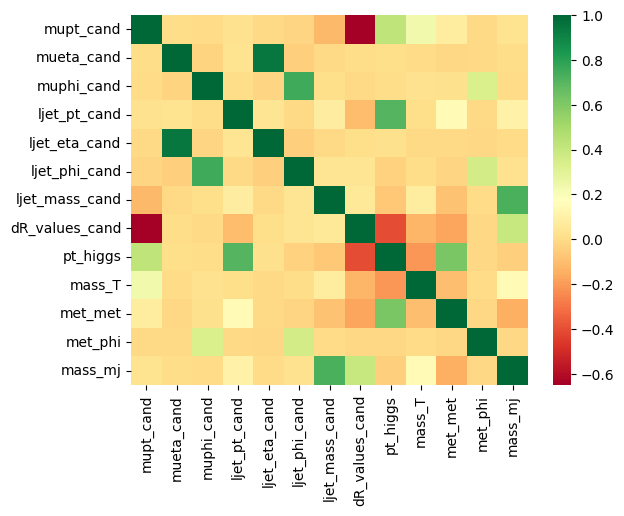

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


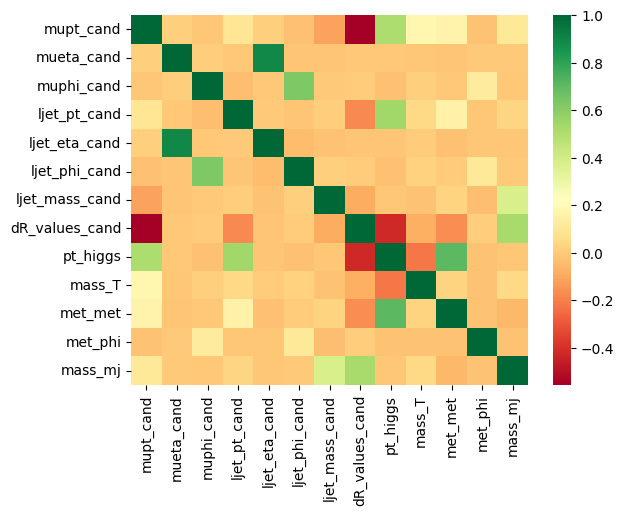

1770    0.014819
2734    0.004795
804     0.007699
3215    0.003804
1766    0.005780
          ...   
2121    0.007528
1717    0.008222
2030    0.006868
2551    0.018980
128     0.005326
Name: weight, Length: 2112, dtype: float64
2161    0.126731
2884    0.129555
3109    0.134770
1207    0.069942
691     0.068523
          ...   
2411    0.131832
1242    0.143005
3468    0.136991
41      0.116801
1436    0.111256
Name: weight, Length: 2220, dtype: float64
Examples:  Total: 4332  Positive: 2112  Negative: 2220  Ratio: 0.48753462603878117
[1 1 1 ... 0 0 0]
[0.01481901 0.00479498 0.00769908 ... 0.13699054 0.11680137 0.1112562 ]
[243.68618116  14.17515529]
Weighted Training Events:  Total: 257.8613364487015  Positive: 14.175155292501373  Negative: 243.6861811562001  Ratio: 0.05497200738863523
Weighted Test Events:  Total: 79.62493502329428  Positive: 4.463127669392716  Negative: 75.16180735390157  Ratio: 0.05605188460231745
Weighted Validation Events:  Total: 64.40194567539639  Positive: 3

In [5]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification', 'mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

# signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
# ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})

# train_df = pd.concat([signal_train_e, ttbar_train_e])
# train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
# train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])
# print(signal_train_weights_e)
# print(ttbar_train_weights_e)

# test_df = pd.concat([signal_test_e, ttbar_test_e])
# test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
# test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

# val_df = pd.concat([signal_val_e, ttbar_val_e])
# val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
# val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])


signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
signal_train_d, signal_train_class_d, signal_train_weights_d, signal_test_d, signal_test_class_d, signal_test_weights_d, signal_val_d, signal_val_class_d, signal_val_weights_d = create_tensor_object(variables, {"signal_d" : signal_file_d})
signal_train_a, signal_train_class_a, signal_train_weights_a, signal_test_a, signal_test_class_a, signal_test_weights_a, signal_val_a, signal_val_class_a, signal_val_weights_a = create_tensor_object(variables, {"signal_a" : signal_file_a})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})
ttbar_train_d, ttbar_train_class_d, ttbar_train_weights_d, ttbar_test_d, ttbar_test_class_d, ttbar_test_weights_d, ttbar_val_d, ttbar_val_class_d, ttbar_val_weights_d  = create_tensor_object(variables, {"ttbar_d" : ttbar_file_d})
ttbar_train_a, ttbar_train_class_a, ttbar_train_weights_a, ttbar_test_a, ttbar_test_class_a, ttbar_test_weights_a, ttbar_val_a, ttbar_val_class_a, ttbar_val_weights_a  = create_tensor_object(variables, {"ttbar_a" : ttbar_file_a})
wjets_train_e, wjets_train_class_e, wjets_train_weights_e, wjets_test_e, wjets_test_class_e, wjets_test_weights_e, wjets_val_e, wjets_val_class_e, wjets_val_weights_e  = create_tensor_object(variables, {"wjets_e" : wjets_file_e})
wjets_train_d, wjets_train_class_d, wjets_train_weights_d, wjets_test_d, wjets_test_class_d, wjets_test_weights_d, wjets_val_d, wjets_val_class_d, wjets_val_weights_d  = create_tensor_object(variables, {"wjets_d" : wjets_file_d})
wjets_train_a, wjets_train_class_a, wjets_train_weights_a, wjets_test_a, wjets_test_class_a, wjets_test_weights_a, wjets_val_a, wjets_val_class_a, wjets_val_weights_a  = create_tensor_object(variables, {"wjets_a" : wjets_file_a})
diboson_train_e, diboson_train_class_e, diboson_train_weights_e, diboson_test_e, diboson_test_class_e, diboson_test_weights_e, diboson_val_e, diboson_val_class_e, diboson_val_weights_e  = create_tensor_object(variables, {"diboson_e" : diboson_file_e})
diboson_train_d, diboson_train_class_d, diboson_train_weights_d, diboson_test_d, diboson_test_class_d, diboson_test_weights_d, diboson_val_d, diboson_val_class_d, diboson_val_weights_d  = create_tensor_object(variables, {"diboson_d" : diboson_file_d})
diboson_train_a, diboson_train_class_a, diboson_train_weights_a, diboson_test_a, diboson_test_class_a, diboson_test_weights_a, diboson_val_a, diboson_val_class_a, diboson_val_weights_a  = create_tensor_object(variables, {"diboson_a" : diboson_file_a})
singletop_train_e, singletop_train_class_e, singletop_train_weights_e, singletop_test_e, singletop_test_class_e, singletop_test_weights_e, singletop_val_e, singletop_val_class_e, singletop_val_weights_e  = create_tensor_object(variables, {"singletop_e" : singletop_file_e})
singletop_train_d, singletop_train_class_d, singletop_train_weights_d, singletop_test_d, singletop_test_class_d, singletop_test_weights_d, singletop_val_d, singletop_val_class_d, singletop_val_weights_d  = create_tensor_object(variables, {"singletop_d" : singletop_file_d})
singletop_train_a, singletop_train_class_a, singletop_train_weights_a, singletop_test_a, singletop_test_class_a, singletop_test_weights_a, singletop_val_a, singletop_val_class_a, singletop_val_weights_a  = create_tensor_object(variables, {"singletop_a" : singletop_file_a})
zjets_train_e, zjets_train_class_e, zjets_train_weights_e, zjets_test_e, zjets_test_class_e, zjets_test_weights_e, zjets_val_e, zjets_val_class_e, zjets_val_weights_e  = create_tensor_object(variables, {"zjets_e" : zjets_file_e})
zjets_train_d, zjets_train_class_d, zjets_train_weights_d, zjets_test_d, zjets_test_class_d, zjets_test_weights_d, zjets_val_d, zjets_val_class_d, zjets_val_weights_d  = create_tensor_object(variables, {"zjets_d" : zjets_file_d})
zjets_train_a, zjets_train_class_a, zjets_train_weights_a, zjets_test_a, zjets_test_class_a, zjets_test_weights_a, zjets_val_a, zjets_val_class_a, zjets_val_weights_a  = create_tensor_object(variables, {"zjets_a" : zjets_file_a})

train_df = pd.concat([signal_train_e, signal_train_d, signal_train_a, ttbar_train_e, ttbar_train_d, ttbar_train_a, diboson_train_e, diboson_train_d, diboson_train_a, singletop_train_e, singletop_train_d, singletop_train_a, zjets_train_e, zjets_train_d, zjets_train_a])
train_class = np.concatenate([signal_train_class_e, signal_train_class_d, signal_train_class_a, ttbar_train_class_e, ttbar_train_class_d, ttbar_train_class_a, diboson_train_class_e, diboson_train_class_d, diboson_train_class_a, singletop_train_class_e, singletop_train_class_d, singletop_train_class_a, zjets_train_class_e, zjets_train_class_d, zjets_train_class_a])
train_weight = np.concatenate([signal_train_weights_e, signal_train_weights_d, signal_train_weights_a, ttbar_train_weights_e, ttbar_train_weights_d, ttbar_train_weights_a, diboson_train_weights_e, diboson_train_weights_d, diboson_train_weights_a, singletop_train_weights_e, singletop_train_weights_d, singletop_train_weights_a, zjets_train_weights_e, zjets_train_weights_d, zjets_train_weights_a])

test_df = pd.concat([signal_test_e, signal_test_d, signal_test_a, ttbar_test_e, ttbar_test_d, ttbar_test_a, diboson_test_e, diboson_test_d, diboson_test_a, singletop_test_e, singletop_test_d, singletop_test_a, zjets_test_e, zjets_test_d, zjets_test_a])
test_class = np.concatenate([signal_test_class_e, signal_test_class_d, signal_test_class_a, ttbar_test_class_e, ttbar_test_class_d, ttbar_test_class_a, diboson_test_class_e, diboson_test_class_d, diboson_test_class_a, singletop_test_class_e, singletop_test_class_d, singletop_test_class_a, zjets_test_class_e, zjets_test_class_d, zjets_test_class_a])
test_weight = np.concatenate([signal_test_weights_e, signal_test_weights_d, signal_test_weights_a, ttbar_test_weights_e, ttbar_test_weights_d, ttbar_test_weights_a, diboson_test_weights_e, diboson_test_weights_d, diboson_test_weights_a, singletop_test_weights_e, singletop_test_weights_d, singletop_test_weights_a, zjets_test_weights_e, zjets_test_weights_d, zjets_test_weights_a])

val_df = pd.concat([signal_val_e, signal_val_d, signal_val_a, ttbar_val_e, ttbar_val_d, ttbar_val_a, diboson_val_e, diboson_val_d, diboson_val_a, singletop_val_e, singletop_val_d, singletop_val_a, zjets_val_e, zjets_val_d, zjets_val_a])
val_class = np.concatenate([signal_val_class_e, signal_val_class_d, signal_val_class_a, ttbar_val_class_e, ttbar_val_class_d, ttbar_val_class_a, diboson_val_class_e, diboson_val_class_d, diboson_val_class_a, singletop_val_class_e, singletop_val_class_d, singletop_val_class_a, zjets_val_class_e, zjets_val_class_d, zjets_val_class_a])
val_weight = np.concatenate([signal_val_weights_e, signal_val_weights_d, signal_val_weights_a, ttbar_val_weights_e, ttbar_val_weights_d, ttbar_val_weights_a, diboson_val_weights_e, diboson_val_weights_d, diboson_val_weights_a, singletop_val_weights_e, singletop_val_weights_d, singletop_val_weights_a, zjets_val_weights_e, zjets_val_weights_d, zjets_val_weights_a])


scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
print(train_class)
print(train_weight)
print(np.bincount(train_class, weights=train_weight))
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [6]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [7]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [8]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
# nn_model = get_model(METRICS, bias, scaled_train_df)
# nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=256, epochs=750, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
validation_data=(scaled_val_df, val_class),
# y_scores = nn_model.predict(scaled_test_df)
# nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input-biginput.h5')
# nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

2022-12-15 21:21:56.141813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/benk/root/root-6.26.10-install/lib
2022-12-15 21:21:56.142723: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 21:21:56.142792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-8QP3M5U): /proc/driver/nvidia/version does not exist
2022-12-15 21:21:56.145211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


43/43 [==============================] - 1s 3ms/step


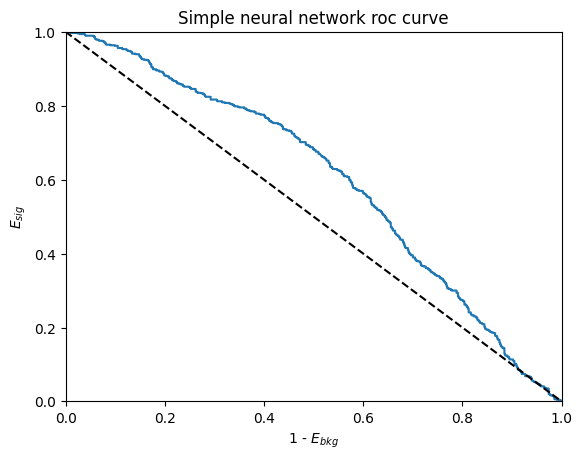

0.5974543707973101


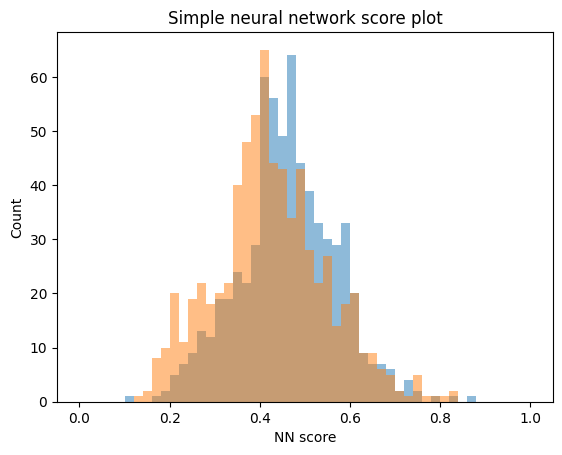

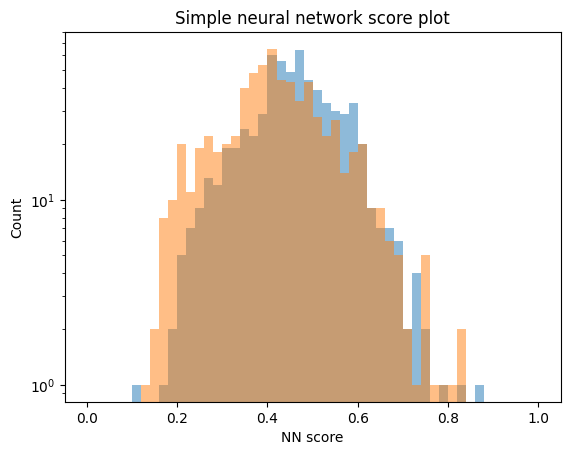

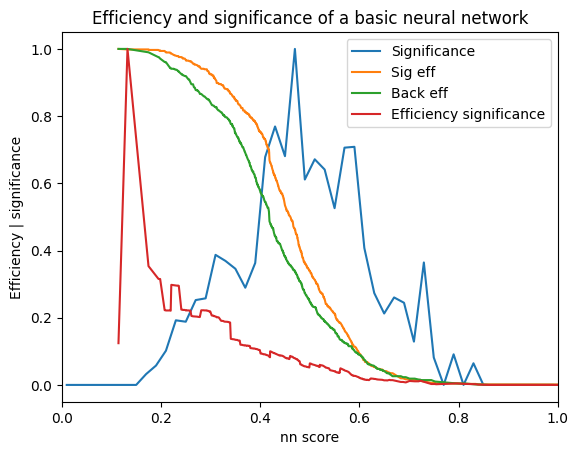

Maximum significance of 1.0 occurs at nn = 0.4699999988079071


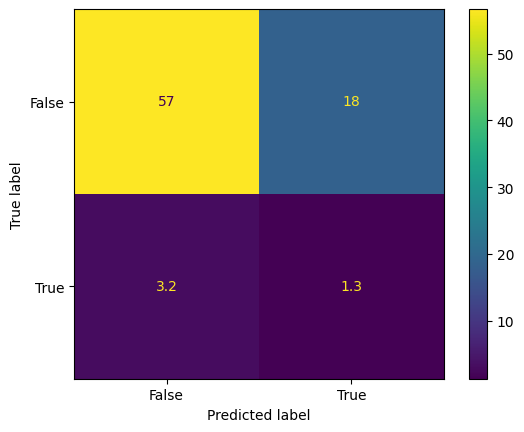

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import models
import math

# nn_model = models.load_model("nn_model_4_hidden_256_128_64_32_16_8_input.h5")
nn_model = models.load_model("nn_model_4_hidden_256_128_64_32_16_8_input-biginput.h5")
y_scores = nn_model.predict(scaled_test_df)

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

# nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

#print("NN AUC: ", auc(nn_fakes, nn_reals))

# nn_loss_plot = plot_loss(nn_fit)
# nn_accuracy_plot = plot_accuracy(nn_fit)

# plot_roc_curve(nn_fakes, nn_reals)

# plot signal and background scores
# plt.plot(nn_fakes, nn_reals, label="NN")
# plt.legend()
# plt.show()

# , weights=test_weight[test_class == 1]
# , weights=test_weight[test_class == 0]

plt.plot(1 - nn_fakes, nn_reals)
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.title("Simple neural network roc curve")
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

# print(len(nn_reals))
# print(len(nn_fakes))
# print(nn_reals)
# print(nn_fakes)

tot = 0;
for i in range(len(nn_reals) - 1):
    # print((1-nn_fakes)[i])
    # print((1-nn_fakes)[i + 1])
    # print(nn_reals[i] * ((1-nn_fakes)[i] - (1-nn_fakes)[i + 1]))
    tot += nn_reals[i] * ((1-nn_fakes)[i] - (1-nn_fakes)[i + 1])
print(tot)

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
plt.title("Simple neural network score plot")
# plt.yscale('log')
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
plt.title("Simple neural network score plot")
plt.yscale('log')
plt.show()

entries = normalize_npArr(entries)
entries1 = normalize_npArr(entries1)

# print(entries)
# print(entries.size)
# print(thresholds)
# print(nn_reals)

# hold the significance values for the entries of the signal and background arrays
significance = np.zeros(entries.size)
# sig 2?
significance2 = np.zeros(thresholds.size)
# holds the center of bins which will 
bin_centers = np.zeros(entries.size)

for i in range(entries.size):
    if(entries1[i]!= 0):
        significance[i] = entries[i] / np.sqrt(entries1[i])
    bin_centers[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

thresholds2 = np.copy(thresholds)
thresholds2[0] = 0.99999;

significance2[significance2.size - 1] = 1
for i in range(thresholds2.size - 1):
    modi = int(math.floor(thresholds2[i] * entries.size))
    if(entries1[modi] != 0):
        significance2[i] = nn_reals[i] / np.sqrt(entries1[modi])

significance = normalize_npArr(significance)
significance2 = normalize_npArr(significance2)

plt.plot(bin_centers, significance, label = "Significance")
plt.plot(thresholds, nn_reals, label = "Sig eff")
plt.plot(thresholds, nn_fakes, label = "Back eff")
plt.plot(thresholds2, significance2, label = "Efficiency significance")
plt.xlabel("nn score")
plt.ylabel("Efficiency | significance")
plt.title("Efficiency and significance of a basic neural network")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(significance)} occurs at nn = {bin_centers[np.where(significance == np.max(significance))][0]}')

# plt.hist(nn_signal_scores, bins=20, alpha = 0.5, label='background')
# plt.xlim([0, 1])
# # plt.yscale('log')
# plt.show()

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [10]:
bdt_model = boosted_decision_tree()

bdt_fit = bdt_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

bdt_y_scores = bdt_model.predict(scaled_test_df)

Use /tmp/tmp1om1gs_7 as temporary training directory


Reading training dataset...
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:10.442790. Found 4332 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1084, shape=(), dtype=int32)
Validation dataset read in 0:00:00.744973. Found 1084 examples.
Training model...


2022-12-15 21:22:13.000523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1765] Subsample hyperparameter given but sampling method does not match.
2022-12-15 21:22:13.000608: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1778] GOSS alpha hyperparameter given but GOSS is disabled.
2022-12-15 21:22:13.000625: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1787] GOSS beta hyperparameter given but GOSS is disabled.
2022-12-15 21:22:13.000634: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1799] SelGB ratio hyperparameter given but SelGB is disabled.
2022-12-15 21:22:13.003713: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:451] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2022-12-15 21:22:13.003822: I external/ydf/yggdrasil_decision_

Model trained in 0:00:01.418084
Compiling model...


2022-12-15 21:22:14.342442: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1567] Create final snapshot of the model at iteration 73
2022-12-15 21:22:14.349435: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2022-12-15 21:22:14.349854: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:44 valid-loss:0.893296 valid-accuracy:0.790590
[INFO 2022-12-15T21:22:14.379527694-05:00 kernel.cc:1175] Loading model from path /tmp/tmp1om1gs_7/model/ with prefix 2f380acab707481d
[INFO 2022-12-15T21:22:14.395162474-05:00 abstract_model.cc:1306] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2022-12-15T21:22:14.395210385-05:00 kernel.cc:1021] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 4ms/step


{'_is_trained': <tf.Variable 'is_trained:0' shape=() dtype=bool, numpy=True>, 'optimizer._iterations': <tf.Variable 'iteration:0' shape=() dtype=int64, numpy=0>, 'optimizer._learning_rate': <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>}
<tf.Variable 'is_trained:0' shape=() dtype=bool, numpy=True>


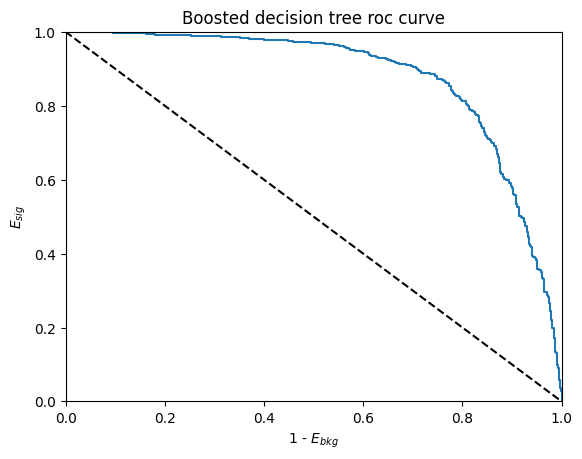

0.8766243122871366


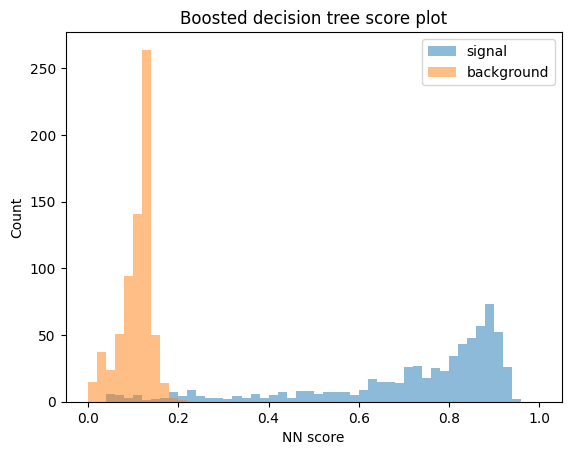

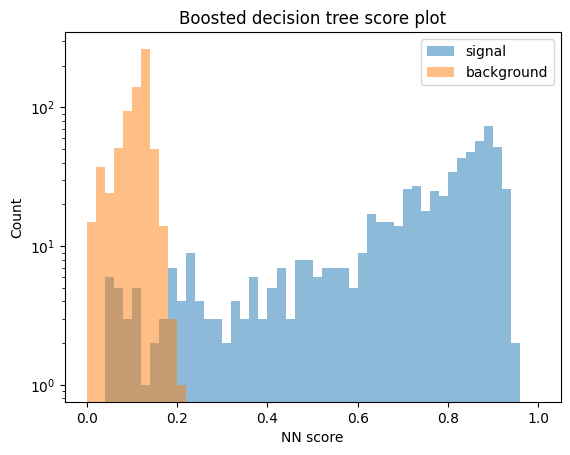

1.0


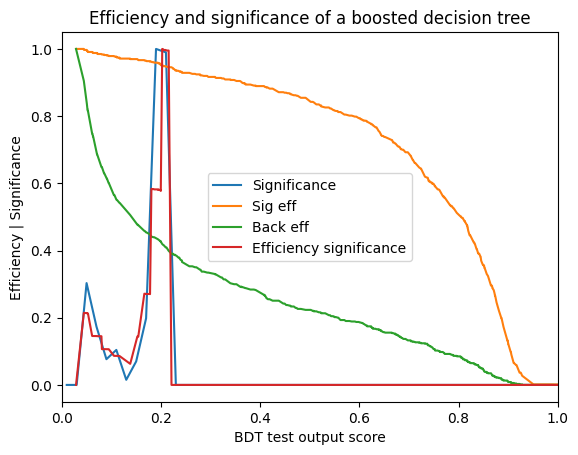

Maximum significance of 1.0 occurs at nn = 0.1900000050663948


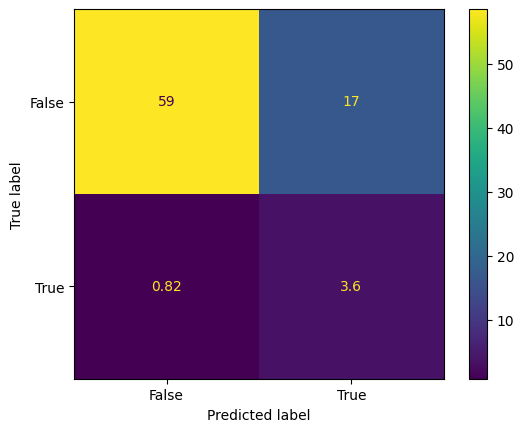

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

print(bdt_model.get_weight_paths())
print(bdt_model.get_weight_paths()["_is_trained"])

bdt_y_pred = np.round(bdt_y_scores)

# bdt_model.summary()

bdt_nn_signal_scores = bdt_y_scores[test_class == 1]
bdt_nn_background_scores = bdt_y_scores[test_class == 0]

bdt_nn_signal_weights = test_weight[test_class == 1]
bdt_nn_background_scores = test_weight[test_class == 0]

bdt_nn_fakes, bdt_nn_reals, bdt_thresholds = roc_curve(test_class, bdt_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - bdt_nn_fakes, bdt_nn_reals)
plt.title("Boosted decision tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

tot = 0;
for i in range(len(bdt_nn_reals) - 1):
    tot += bdt_nn_reals[i] * ((1-bdt_nn_fakes)[i] - (1-bdt_nn_fakes)[i + 1])
print(tot)

#plot signal and background scores
bdt_entries, bdt_bin_edges, bdt_c = plt.hist(bdt_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
bdt_entries1, bdt_bin_edges1, bdt_c1 = plt.hist(bdt_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Boosted decision tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()

#plot signal and background scores
bdt_entries, bdt_bin_edges, bdt_c = plt.hist(bdt_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
bdt_entries1, bdt_bin_edges1, bdt_c1 = plt.hist(bdt_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Boosted decision tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
plt.yscale('log')
plt.show()

bdt_entries = normalize_npArr(bdt_entries)
bdt_entries1 = normalize_npArr(bdt_entries1)

# hold the significance values for the entries of the signal and background arrays
bdt_significance = np.zeros(bdt_entries.size)
# holds the center of bins which will 
bdt_bin_centers = np.zeros(bdt_entries.size)
bdt_significance2 = np.zeros(bdt_thresholds.size)

for i in range(bdt_entries.size):
    if(bdt_entries1[i]!= 0):
        bdt_significance[i] = bdt_entries[i] / np.sqrt(bdt_entries1[i])
    bdt_bin_centers[i] = (bdt_bin_edges[i] + bdt_bin_edges[i + 1]) / 2

bdt_thresholds2 = np.copy(bdt_thresholds)
bdt_thresholds2[0] = 0.99999;

for i in range(bdt_thresholds2.size - 1):
    modi = int(math.floor(bdt_thresholds2[i] * bdt_entries.size))
    if(bdt_entries1[modi] != 0):
        bdt_significance2[i] = bdt_nn_reals[i] / np.sqrt(bdt_entries1[modi])

bdt_significance = normalize_npArr(bdt_significance)
bdt_significance2 = normalize_npArr(bdt_significance2)

print(max(bdt_significance2))

plt.plot(bdt_bin_centers, bdt_significance, label = "Significance")
plt.plot(bdt_thresholds, bdt_nn_reals, label = "Sig eff")
plt.plot(bdt_thresholds, bdt_nn_fakes, label = "Back eff")
plt.plot(bdt_thresholds2, bdt_significance2, label = "Efficiency significance")
plt.xlabel("BDT test output score")
plt.ylabel("Efficiency | Significance")
plt.title("Efficiency and significance of a boosted decision tree")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(bdt_significance)} occurs at nn = {bdt_bin_centers[np.where(bdt_significance == np.max(bdt_significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
bdt_confmatrix = confusion_matrix(test_class, bdt_y_pred, sample_weight=test_weight)
bdt_cm_display = ConfusionMatrixDisplay(confusion_matrix = bdt_confmatrix, display_labels = [False, True])
bdt_cm_display.plot()
plt.show()

In [12]:
rft_model = random_forest_tree()

rft_fit = rft_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

rft_y_scores = rft_model.predict(scaled_test_df)

Use /tmp/tmpre868jvg as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.586282. Found 4332 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1084, shape=(), dtype=int32)
Validation dataset read in 0:00:00.439488. Found 1084 examples.
Training model...


[INFO 2022-12-15T21:22:25.645435725-05:00 kernel.cc:1175] Loading model from path /tmp/tmpre868jvg/model/ with prefix 64643daf69f54f98


Model trained in 0:00:02.188743
Compiling model...


[INFO 2022-12-15T21:22:26.238212262-05:00 abstract_model.cc:1306] Engine "RandomForestOptPred" built
[INFO 2022-12-15T21:22:26.238279881-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 7ms/step


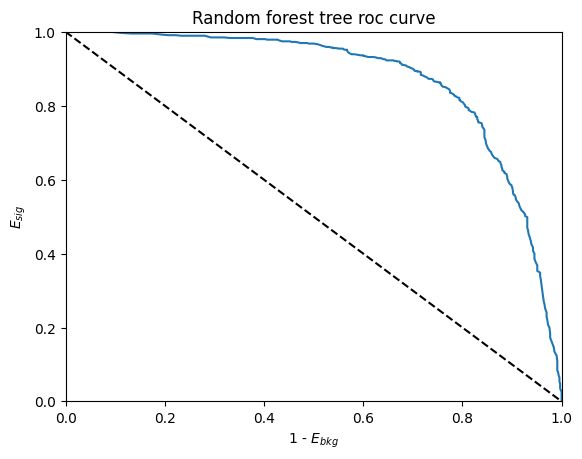

0.8714872063575235


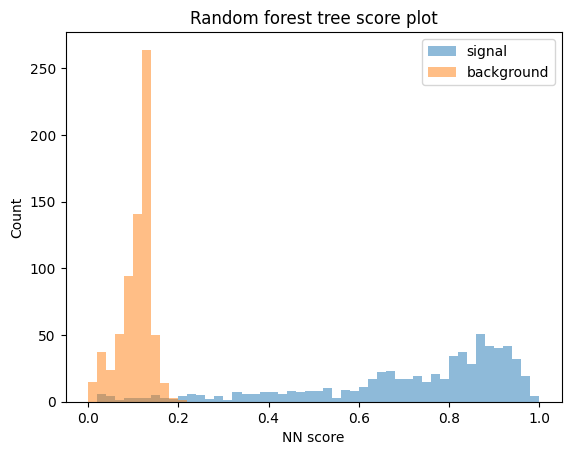

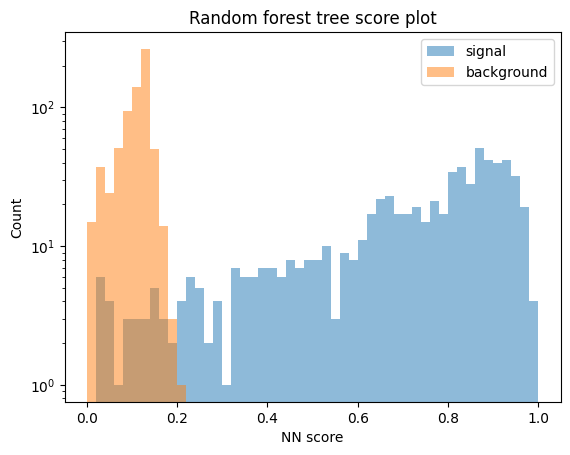

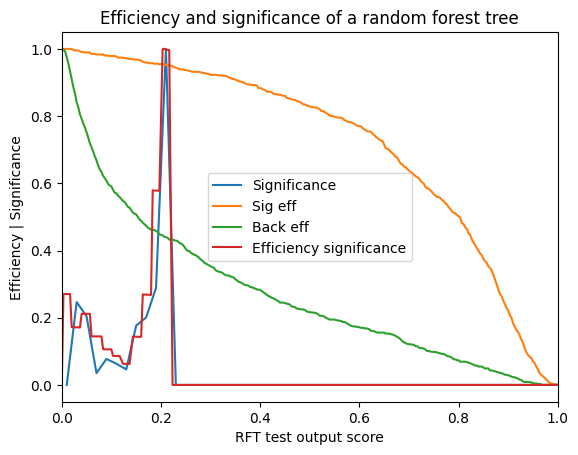

Maximum significance of 1.0 occurs at nn = 0.21000000089406967


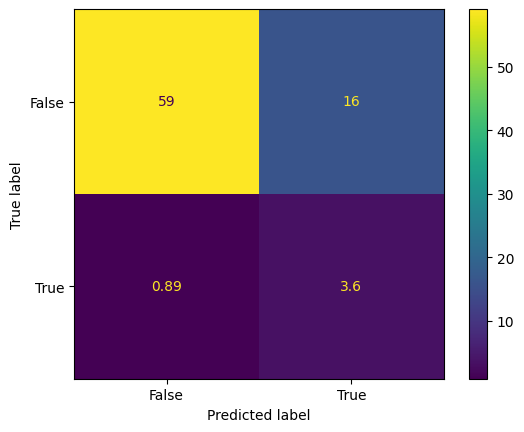

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

rft_y_pred = np.round(rft_y_scores)

# rft_model.summary()

rft_nn_signal_scores = rft_y_scores[test_class == 1]
rft_nn_background_scores = rft_y_scores[test_class == 0]

rft_nn_signal_weights = test_weight[test_class == 1]
rft_nn_background_scores = test_weight[test_class == 0]

rft_nn_fakes, rft_nn_reals, rft_thresholds = roc_curve(test_class, rft_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - rft_nn_fakes, rft_nn_reals)
plt.title("Random forest tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

tot = 0;
for i in range(len(rft_nn_reals) - 1):
    tot += rft_nn_reals[i] * ((1-rft_nn_fakes)[i] - (1-rft_nn_fakes)[i + 1])
print(tot)

#plot signal and background scores
rft_entries, rft_bin_edges, rft_c = plt.hist(rft_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
rft_entries1, rft_bin_edges1, rft_c1 = plt.hist(rft_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Random forest tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()

#plot signal and background scores
rft_entries, rft_bin_edges, rft_c = plt.hist(rft_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
rft_entries1, rft_bin_edges1, rft_c1 = plt.hist(rft_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.title("Random forest tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
plt.yscale('log')
plt.show()

rft_entries = normalize_npArr(rft_entries)
rft_entries1 = normalize_npArr(rft_entries1)

# hold the significance values for the entries of the signal and background arrays
rft_significance = np.zeros(rft_entries.size)
# holds the center of bins which will 
rft_bin_centers = np.zeros(rft_entries.size)
rft_significance2 = np.zeros(rft_thresholds.size)

for i in range(rft_entries.size):
    if(rft_entries1[i]!= 0):
        rft_significance[i] = rft_entries[i] / np.sqrt(rft_entries1[i])
    rft_bin_centers[i] = (rft_bin_edges[i] + rft_bin_edges[i + 1]) / 2

rft_thresholds2 = np.copy(rft_thresholds)
rft_thresholds2[0] = 0.99999;

for i in range(rft_thresholds2.size - 1):
    modi = int(math.floor(rft_thresholds2[i] * rft_entries.size))
    if(rft_entries1[modi] != 0):
        rft_significance2[i] = rft_nn_reals[i] / np.sqrt(rft_entries1[modi])

rft_significance = normalize_npArr(rft_significance)
rft_significance2 = normalize_npArr(rft_significance2)

plt.plot(rft_bin_centers, rft_significance, label = "Significance")
plt.plot(rft_thresholds, rft_nn_reals, label = "Sig eff")
plt.plot(rft_thresholds, rft_nn_fakes, label = "Back eff")
plt.plot(rft_thresholds2, rft_significance2, label = "Efficiency significance")
plt.xlabel("RFT test output score")
plt.ylabel("Efficiency | Significance")
plt.title("Efficiency and significance of a random forest tree")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(rft_significance)} occurs at nn = {rft_bin_centers[np.where(rft_significance == np.max(rft_significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
rft_confmatrix = confusion_matrix(test_class, rft_y_pred, sample_weight=test_weight)
rft_cm_display = ConfusionMatrixDisplay(confusion_matrix = rft_confmatrix, display_labels = [False, True])
rft_cm_display.plot()
plt.show()

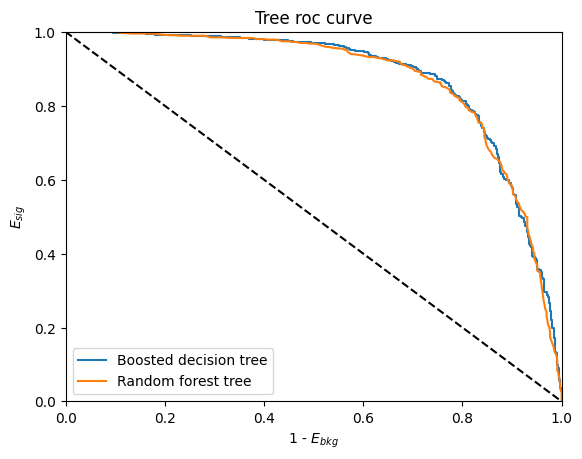

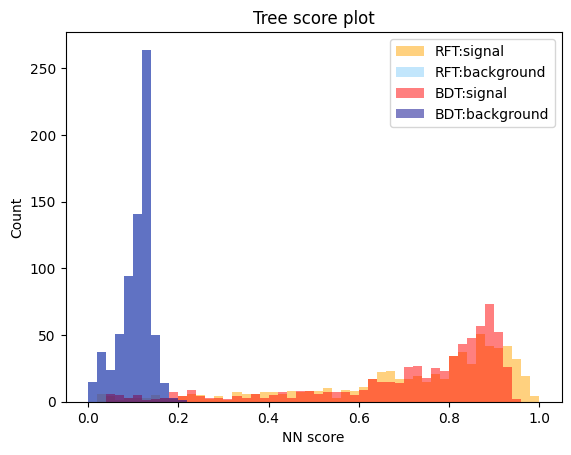

In [14]:
plt.plot(1 - bdt_nn_fakes, bdt_nn_reals, label = "Boosted decision tree")
plt.plot(1 - rft_nn_fakes, rft_nn_reals, label = "Random forest tree")
plt.title("Tree roc curve")
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

#plot signal and background scores
rft_entries, rft_bin_edges, rft_c = plt.hist(rft_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='RFT:signal', color = 'orange')
rft_entries1, rft_bin_edges1, rft_c1 = plt.hist(rft_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='RFT:background', color = 'lightskyblue')
bdt_entries, bdt_bin_edges, bdt_c = plt.hist(bdt_nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='BDT:signal', color = 'red')
bdt_entries1, bdt_bin_edges1, bdt_c1 = plt.hist(bdt_nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='BDT:background', color = "darkblue")
plt.title("Tree score plot")
plt.xlabel('NN score')
plt.ylabel('Count')
plt.legend()
# plt.yscale('log')
plt.show()